In [274]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from datetime import timedelta

In [275]:
import pandas as pd

dataframes = []

for year in range(2008, 2024):
    file_path = f"../data/train_{year}.parquet"
    try:
        df = pd.read_parquet(file_path)
        dataframes.append(df)
    except Exception as e:
        print(f"Failed to read file {file_path}: {e}")
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Total rows in the combined DataFrame: {len(combined_df)}")
else:
    print("No files were successfully read.")

Total rows in the combined DataFrame: 3926058


In [276]:
df_aggregated = combined_df[['customer_id','atm_transfer_in', 'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out', 'bank_transfer_in_volume', 'bank_transfer_out_volume', 'crypto_in', 'crypto_out', 'crypto_in_volume','crypto_out_volume']].groupby('customer_id').mean()
df_aggregated

,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in,crypto_out,crypto_in_volume,crypto_out_volume
customer_id,,,,,,,,,,
1,0.00,0.00,2879.30,552.82,1871.17,976.42,8.58,3.01,104.30,44.09
2,0.30,0.00,412.64,2.02,624.55,90.73,2.10,1.93,50.29,15.69
3,0.00,0.45,497.12,149.17,1401.00,656.51,2.80,1.81,99.35,36.86
4,0.00,0.00,2.02,254.05,91.21,33.56,1.00,1.00,125.58,20.63
5,0.00,0.00,383.13,164.24,799.17,279.28,3.83,1.79,103.09,27.42
...,...,...,...,...,...,...,...,...,...,...
106182,0.00,0.00,597.00,107.00,712.28,101.79,1.00,1.00,44.45,13.60
106183,0.00,0.00,2.00,959.00,94.60,32.78,1.00,1.00,107.13,22.90
106184,0.00,0.00,1.00,2.00,26.65,13.86,5.00,7.00,39.53,12.53


In [277]:
combined_df[(combined_df['complaints'] > 0 ) & (combined_df['bank_transfer_in'] == 0) & (combined_df['bank_transfer_out'] == 0) & (combined_df['atm_transfer_in'] == 0) & (combined_df['atm_transfer_out'] == 0) & (combined_df['crypto_in'] == 0) & (combined_df['crypto_out'] == 0)]

,Id,customer_id,interest_rate,name,country,date_of_birth,address,date,atm_transfer_in,atm_transfer_out,...,crypto_in_volume,crypto_out_volume,complaints,touchpoints,csat_scores,tenure,from_competitor,job,churn_due_to_fraud,model_predicted_fraud


In [278]:
latest_3_records = combined_df.sort_values(by=['customer_id', 'date'], ascending=[True, False]).groupby('customer_id').head(3)

avg_values = latest_3_records.groupby('customer_id')[['bank_transfer_out_volume', 'crypto_out_volume']].mean().reset_index()

print(avg_values)


        customer_id  bank_transfer_out_volume  crypto_out_volume
0                 1                     66.17              37.22
1                 2                     13.27              14.40
2                 3                  24284.73             808.64
3                 4                     33.15              19.28
4                 5                    378.34              59.26
...             ...                       ...                ...
106174       106182                    101.79              13.60
106175       106183                     32.78              22.90
106176       106184                     13.86              12.53
106177       106185                     27.46              17.94
106178       106186                    131.55              15.23

[106179 rows x 3 columns]


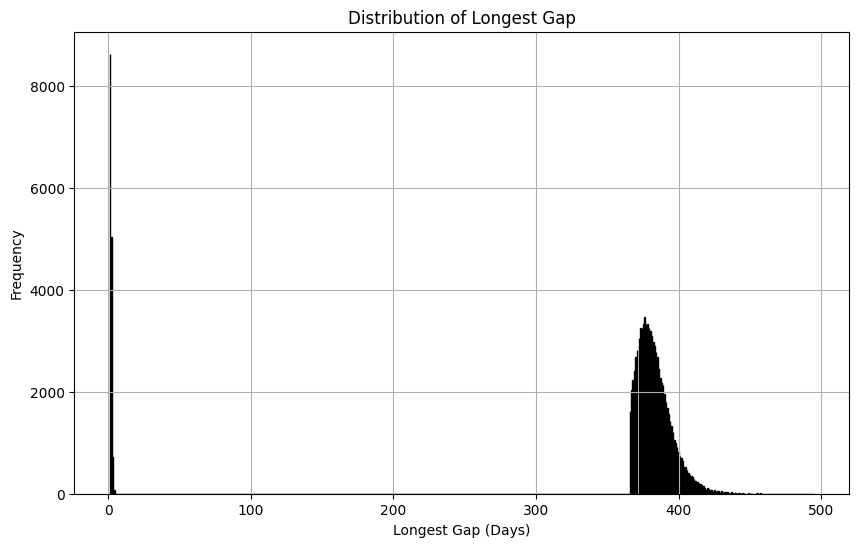

In [279]:
gap_diff_df = combined_df.sort_values(by=['customer_id', 'date'])
gap_diff_df['time_diff'] = gap_diff_df.groupby('customer_id')['date'].diff()
longest_gap = gap_diff_df.groupby('customer_id')['time_diff'].max()

longest_gap_days = longest_gap.dt.total_seconds() / (60 * 60 * 24)  

plt.figure(figsize=(10, 6))
plt.hist(longest_gap_days.dropna(), bins=1000, edgecolor='black', color='skyblue')  
plt.title('Distribution of Longest Gap')
plt.xlabel('Longest Gap (Days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [280]:
last_interaction = combined_df.groupby('customer_id')['date'].max()

churn_date = pd.Timestamp('2023-12-31')
cutoff_date = churn_date - pd.DateOffset(months=18)

churn_status = last_interaction <= cutoff_date

df_train = churn_status.reset_index(name='churn_status')

len(df_train[df_train['churn_status'] == True]) / len(df_train) * 100

19.95498168187683

## Data Cleaning

### ATM Transfer Out

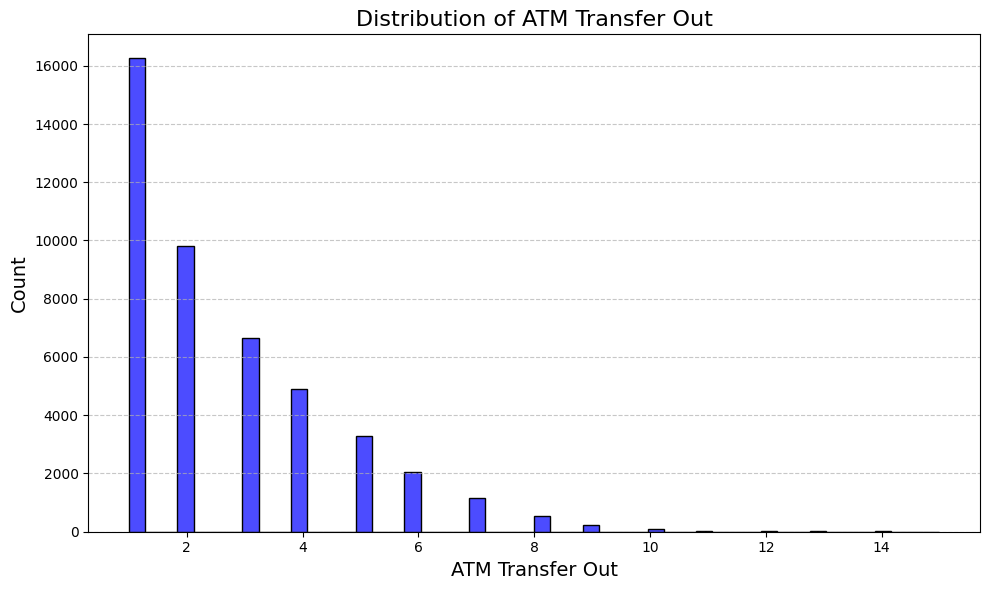

In [281]:
import matplotlib.pyplot as plt
import seaborn as sns

filtered_data = combined_df[(combined_df['atm_transfer_out'] > 0) & (combined_df['atm_transfer_out'] <= 20)]
# filtered_data = combined_df[combined_df['atm_transfer_out'] > 0]


plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['atm_transfer_out'], bins=50, color='blue', edgecolor='black', alpha=0.7)

plt.title('Distribution of ATM Transfer Out', fontsize=16)
plt.xlabel('ATM Transfer Out', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [282]:
len(filtered_data[filtered_data['atm_transfer_out'] > 10]) / len(filtered_data) * 100

0.19288754877616177

In [283]:
combined_df = combined_df[combined_df["atm_transfer_out"] <= 10]
len(combined_df)

3924616

### ATM Transfer In

In [284]:
# len(combined_df[combined_df['atm_transfer_in'] >= 1]) / len(combined_df) * 100
max(combined_df['atm_transfer_in'])

2325

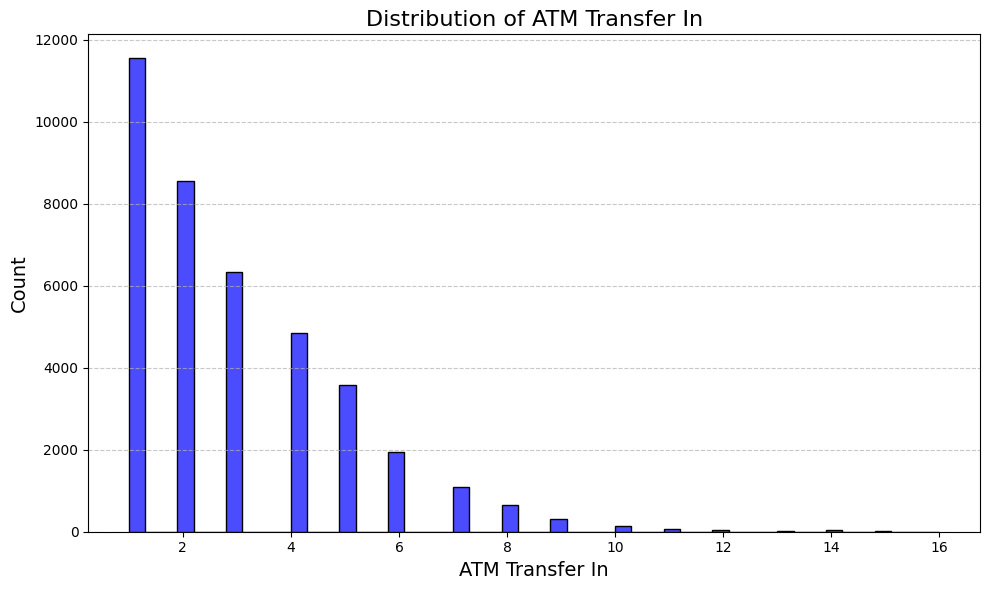

In [285]:
# GABBY 
# filtered_data = combined_df[(combined_df['atm_transfer_out'] > 0) & (combined_df['atm_transfer_out'] <= 20)]
filtered_data = combined_df[(combined_df['atm_transfer_in'] > 0) & (combined_df['atm_transfer_in'] <= 20)]


plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['atm_transfer_in'], bins=50, color='blue', edgecolor='black', alpha=0.7)

plt.title('Distribution of ATM Transfer In', fontsize=16)
plt.xlabel('ATM Transfer In', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

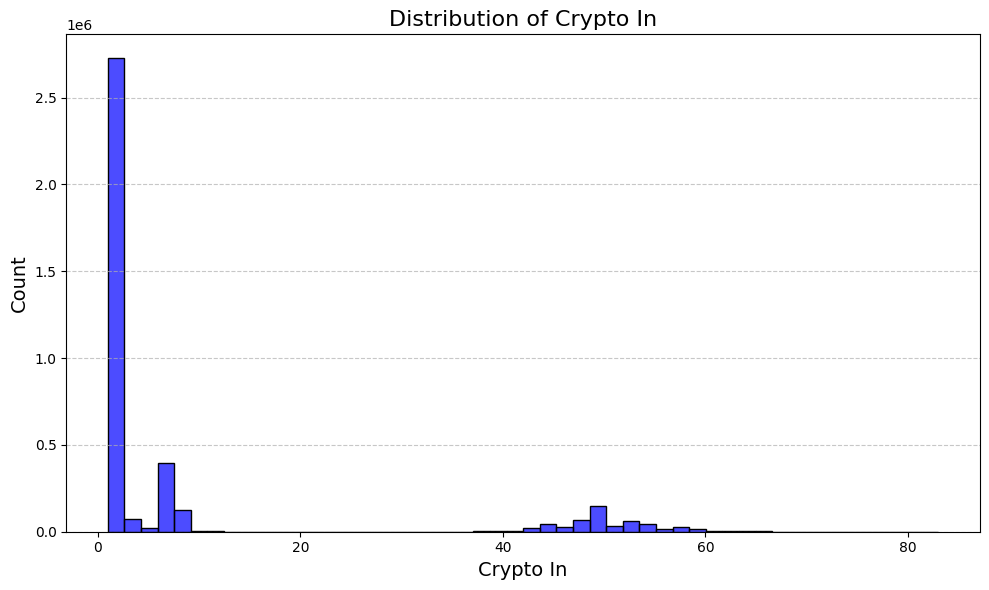

In [286]:
# GABBY 2
# filtered_data = combined_df[(combined_df['atm_transfer_out'] > 0) & (combined_df['atm_transfer_out'] <= 20)]
filtered_data = combined_df[(combined_df['crypto_in'] > 0) & (combined_df['crypto_in'] <= 100)]


plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['crypto_in'], bins=50, color='blue', edgecolor='black', alpha=0.7)

plt.title('Distribution of Crypto In', fontsize=16)
plt.xlabel('Crypto In', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [287]:
combined_df['crypto_in'].unique()

array([56, 46, 48, 49, 60, 52, 55, 53, 57, 45, 58, 54, 51, 50,  1,  5,  4,
        6,  2,  7,  8,  9,  3, 41, 42, 43, 38, 47, 59, 44, 62, 10, 61, 40,
       64, 63, 75, 39, 71, 23, 21, 25, 24, 22, 20, 27, 28, 26, 29, 19, 18,
       30, 12, 11, 13,  0, 34, 31, 33, 35, 65, 37, 14, 66, 15, 16, 36, 32,
       68, 67, 69, 17, 74, 73, 70, 72, 83, 77, 79, 76, 81, 78, 80])

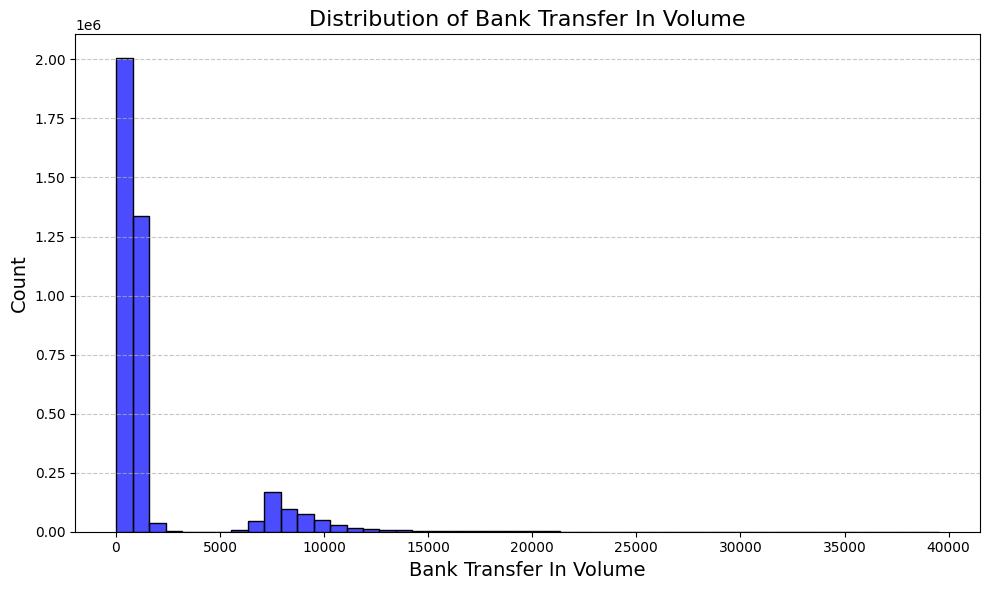

In [288]:
filtered_data = combined_df
# filtered_data = combined_df[(combined_df['bank_transfer_in_volume'] > 0) & (combined_df['crypto_in'] <= 100)]


plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['bank_transfer_in_volume'], bins=50, color='blue', edgecolor='black', alpha=0.7)

plt.title('Distribution of Bank Transfer In Volume', fontsize=16)
plt.xlabel('Bank Transfer In Volume', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

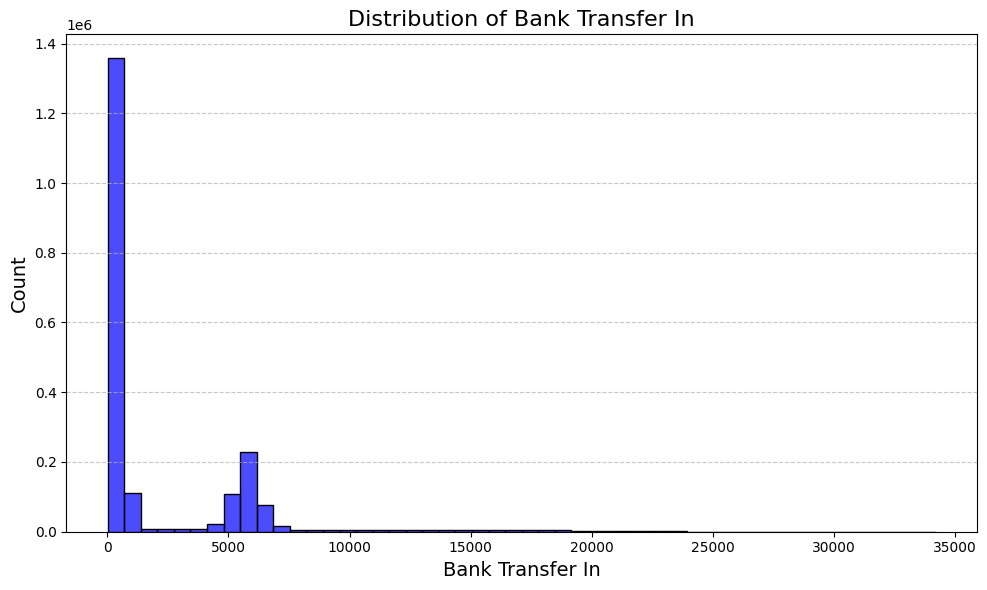

In [289]:
#len(combined_df[combined_df['bank_transfer_in'] > 80]) / len(combined_df) * 100

# filtered_data = combined_df[(combined_df['bank_transfer_in'] > 0) & (combined_df['bank_transfer_in'] <= 20)]
filtered_data = combined_df[combined_df['bank_transfer_in'] > 10]


plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['bank_transfer_in'], bins=50, color='blue', edgecolor='black', alpha=0.7)

plt.title('Distribution of Bank Transfer In', fontsize=16)
plt.xlabel('Bank Transfer In', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [290]:
max(combined_df['bank_transfer_in'])

34209

In [291]:
percentile_98 = np.percentile(combined_df['bank_transfer_in'], 98)

print("98th Percentile:", percentile_98)
print("Max Value:", max(combined_df['bank_transfer_in']))

raw_mean = combined_df['bank_transfer_in'].mean()
print("Raw Mean:", raw_mean)

Q1 = combined_df['bank_transfer_in'].quantile(0.25)
Q3 = combined_df['bank_transfer_in'].quantile(0.75)
IQR = Q3 - Q1

filtered_df = combined_df[
    (combined_df['bank_transfer_in'] >= (Q1 - 1.5 * IQR)) &
    (combined_df['bank_transfer_in'] <= (Q3 + 1.5 * IQR))
]


98th Percentile: 8224.0
Max Value: 34209
Raw Mean: 1183.1775985217407


In [292]:
filtered_data = combined_df[combined_df['bank_transfer_in'] <= 8224.0]

last_interaction = filtered_data.groupby('customer_id')['date'].max()

churn_date = pd.Timestamp('2023-12-31')
cutoff_date = churn_date - pd.DateOffset(months=18)

churn_status = last_interaction <= cutoff_date

df_train = churn_status.reset_index(name='churn_status')

len(df_train[df_train['churn_status'] == True]) / len(df_train) * 100

20.12499762542505

# Baseline

## Feature Engineering

- country
- customer age
- customer job category

In [293]:
last_interaction = combined_df.groupby('customer_id')['date'].max()

churn_date = pd.Timestamp('2023-12-31')
cutoff_date = churn_date - pd.DateOffset(months=18)

churn_status = last_interaction <= cutoff_date

df_train = churn_status.reset_index(name='churn_status')

len(df_train[df_train['churn_status'] == True]) / len(df_train) * 100

19.95742516436524

In [294]:
import pandas as pd
import numpy as np  # Import numpy explicitly

# Merge dataframes on customer_id
merged_df = combined_df.merge(df_train, on="customer_id", how="inner")

# Categorizing based on model_predicted_fraud and churn_status
conditions = [
    (merged_df["model_predicted_fraud"] == True) & (merged_df["churn_status"] == True),
    (merged_df["model_predicted_fraud"] == False) & (merged_df["churn_status"] == False),
    (merged_df["model_predicted_fraud"] == True) & (merged_df["churn_status"] == False),
    (merged_df["model_predicted_fraud"] == False) & (merged_df["churn_status"] == True)
]

categories = ["Both True", "Both False", "Fraud True, Churn False", "Fraud False, Churn True"]

# Use numpy.select instead of pd.np.select
merged_df["Category"] = np.select(conditions, categories, default="Unknown")

# Count occurrences of each category
category_counts = merged_df["Category"].value_counts()

# Display results
print(category_counts)


Category
Both False                 2652770
Fraud False, Churn True    1270094
Both True                      896
Fraud True, Churn False        856
Name: count, dtype: int64


In [295]:
type(combined_df['date_of_birth'][0])

datetime.date

In [296]:
combined_df['date_of_birth']

0          1954-07-10
1          1954-07-10
2          1954-07-10
3          1954-07-10
4          1954-07-10
              ...    
3926053    1998-12-27
3926054    1977-04-15
3926055    1983-06-11
3926056    1941-08-27
3926057    1974-04-18
Name: date_of_birth, Length: 3924616, dtype: object

In [297]:
combined_df.columns

Index(['Id', 'customer_id', 'interest_rate', 'name', 'country',
       'date_of_birth', 'address', 'date', 'atm_transfer_in',
       'atm_transfer_out', 'bank_transfer_in', 'bank_transfer_out',
       'crypto_in', 'crypto_out', 'bank_transfer_in_volume',
       'bank_transfer_out_volume', 'crypto_in_volume', 'crypto_out_volume',
       'complaints', 'touchpoints', 'csat_scores', 'tenure', 'from_competitor',
       'job', 'churn_due_to_fraud', 'model_predicted_fraud'],
      dtype='object')

In [298]:
# Group by customer_id to find the last interaction date
last_interaction = combined_df.groupby('customer_id')['date'].max()

# Define churn date and cutoff date
churn_date = pd.Timestamp('2023-12-31')
cutoff_date = churn_date - pd.DateOffset(months=18)

# Determine churn status based on the cutoff date
churn_status = last_interaction <= cutoff_date

# Create df_train with churn status
df_train = churn_status.reset_index(name='churn_status')

In [299]:
import pandas as pd

# One-hot encode the 'country' column
country_one_hot = pd.get_dummies(combined_df['country'], prefix='country')

# Group by customer_id to find the last interaction date
last_interaction = combined_df.groupby('customer_id')['date'].max()

# Define churn date and cutoff date
churn_date = pd.Timestamp('2023-12-31')
cutoff_date = churn_date - pd.DateOffset(months=18)

# Determine churn status based on the cutoff date
churn_status = last_interaction <= cutoff_date

# Create df_train with churn status
df_train = churn_status.reset_index(name='churn_status')

# Compute age as of 2023-12-31
combined_df['date_of_birth'] = pd.to_datetime(combined_df['date_of_birth'])
age = (pd.Timestamp('2023-12-31') - combined_df.groupby('customer_id')['date_of_birth'].min()).dt.days // 365

# Convert to DataFrame and merge with df_train
age_df = age.reset_index(name='age')
df_train = df_train.merge(age_df, on='customer_id')

# Merge one-hot encoded 'country' columns into df_train
df_train = pd.merge(df_train, combined_df[['customer_id']].drop_duplicates().merge(country_one_hot, left_index=True, right_index=True), on='customer_id')

# Calculate churn percentage
churn_percentage = len(df_train[df_train['churn_status'] == True]) / len(df_train) * 100
print(f"Churn percentage: {churn_percentage:.2f}%")

# Display final df_train
df_train.head()


Churn percentage: 19.96%


,customer_id,churn_status,age,country_Austria,country_Belgium,country_Bulgaria,country_Czech Republic,country_Denmark,country_Estonia,country_Finland,...,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Romania,country_Slovakia,country_Spain,country_Sweden,country_Switzerland,country_USA
0,1,False,69,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,True,76,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,True,21,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,4,True,50,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,5,False,17,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [300]:
df_train

,customer_id,churn_status,age,country_Austria,country_Belgium,country_Bulgaria,country_Czech Republic,country_Denmark,country_Estonia,country_Finland,...,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Romania,country_Slovakia,country_Spain,country_Sweden,country_Switzerland,country_USA
0,1,False,69,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,True,76,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,True,21,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,4,True,50,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,5,False,17,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106161,106182,False,25,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
106162,106183,False,46,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
106163,106184,False,40,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
106164,106185,False,82,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [301]:
# last_interaction = combined_df.groupby('customer_id')['date'].max()

# churn_date = pd.Timestamp('2023-12-31')
# cutoff_date = churn_date - pd.DateOffset(months=18)

# churn_status = last_interaction <= cutoff_date

# df_train = churn_status.reset_index(name='churn_status')
# df_train


# # # Calculate age
# today = pd.Timestamp.now()
# combined_df['age'] = (today - combined_df['date_of_birth']).dt.days // 365


# # Function to determine generation based on age
# def determine_generation(age):
#     if age < 10:
#         return 'Gen Alpha'
#     elif age < 26:
#         return 'Gen Z'
#     elif age < 42:
#         return 'Millennial'
#     elif age < 58:
#         return 'Gen X'
#     elif age < 76:
#         return 'Baby Boomer'
#     else:
#         return 'Silent Generation'
    

# combined_df['generation'] = combined_df['age'].apply(determine_generation)

# combined_df# # # # # # # # # # # # # # # # # # 

## Exploration of [Job]

In [302]:
unemployment_keywords = ["unemployed"]

combined_df['is_unemployed'] = combined_df['job'].str.lower().str.contains('|'.join(unemployment_keywords), na=False)

unemployed_count = combined_df['is_unemployed'].sum()
print(f"Number of unemployed individuals: {unemployed_count}")


Number of unemployed individuals: 349404


In [303]:
df_train

,customer_id,churn_status,age,country_Austria,country_Belgium,country_Bulgaria,country_Czech Republic,country_Denmark,country_Estonia,country_Finland,...,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Romania,country_Slovakia,country_Spain,country_Sweden,country_Switzerland,country_USA
0,1,False,69,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,True,76,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,True,21,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,4,True,50,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,5,False,17,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106161,106182,False,25,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
106162,106183,False,46,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
106163,106184,False,40,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
106164,106185,False,82,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [304]:
df_baseline = pd.merge(df_train, df_aggregated, how = "left", on = "customer_id")
df_baseline

,customer_id,churn_status,age,country_Austria,country_Belgium,country_Bulgaria,country_Czech Republic,country_Denmark,country_Estonia,country_Finland,...,atm_transfer_in,atm_transfer_out,bank_transfer_in,bank_transfer_out,bank_transfer_in_volume,bank_transfer_out_volume,crypto_in,crypto_out,crypto_in_volume,crypto_out_volume
0,1,False,69,False,False,False,False,False,False,False,...,0.00,0.00,2879.30,552.82,1871.17,976.42,8.58,3.01,104.30,44.09
1,2,True,76,False,False,False,False,False,False,False,...,0.30,0.00,412.64,2.02,624.55,90.73,2.10,1.93,50.29,15.69
2,3,True,21,False,False,False,False,False,False,False,...,0.00,0.45,497.12,149.17,1401.00,656.51,2.80,1.81,99.35,36.86
3,4,True,50,False,False,False,False,False,False,False,...,0.00,0.00,2.02,254.05,91.21,33.56,1.00,1.00,125.58,20.63
4,5,False,17,False,False,False,False,False,False,False,...,0.00,0.00,383.13,164.24,799.17,279.28,3.83,1.79,103.09,27.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106161,106182,False,25,False,False,False,False,False,False,False,...,0.00,0.00,597.00,107.00,712.28,101.79,1.00,1.00,44.45,13.60
106162,106183,False,46,False,False,False,False,False,False,False,...,0.00,0.00,2.00,959.00,94.60,32.78,1.00,1.00,107.13,22.90
106163,106184,False,40,False,False,False,True,False,False,False,...,0.00,0.00,1.00,2.00,26.65,13.86,5.00,7.00,39.53,12.53
106164,106185,False,82,False,False,False,False,False,False,False,...,1.00,0.00,2.00,2.00,83.23,27.46,1.00,1.00,121.82,17.94


In [310]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')  # Uncomment this if you're loading from a CSV

# Define the target and features
X = df_baseline.drop(columns=['churn_status', 'customer_id'])  # Drop target and any non-feature columns
y = df_baseline['churn_status']  # The target column

# Scale features to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)  # You can increase `max_iter` if convergence issues occur
model.fit(X_scaled, y)

# Predict the churn status
y_pred = model.predict(X_scaled)

# Evaluate the model
accuracy = accuracy_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)
class_report = classification_report(y, y_pred)
auc = roc_auc_score(y, model.predict_proba(X_scaled)[:, 1])

# Print the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print(f"AUC: {auc}")


Accuracy: 0.8002938793964169
Confusion Matrix:
[[84964    14]
 [21188     0]]
Classification Report:
              precision    recall  f1-score   support

       False       0.80      1.00      0.89     84978
        True       0.00      0.00      0.00     21188

    accuracy                           0.80    106166
   macro avg       0.40      0.50      0.44    106166
weighted avg       0.64      0.80      0.71    106166

AUC: 0.6840720200086168
